##Pengkodean
1. Pengolahan Data ke CSV,
2. Inisialisasi Individu-Populasi & Diskritisasi (Ranking untuk TSP / Sigmoid untuk KP),
3. Inisialisasi Parameter pada metode,
4. Pengkodean tahap awal - generasi pertama'
5. Pengkodean tahap kedua - metode masing masing kelompok ,
6. Pengkodean tahap ketiga - analisis dengan grafik dan eksperimen terhadap parameter.

In [ ]:
# Import Data

import pandas as pd
import numpy as np

df = pd.read_csv('Avocado_baru.csv')
df = pd.DataFrame(df)
profit = df['Average Price'] = df['Average Price'].values/10**9
weight = df['Total Volume'] = df['Total Volume'].values/10**6
df

# Weight : total volume
# Avg Price = Profit

,Unnamed: 0,Tanggal,Average Price,Total Volume,Type
0,0,4/1/2021,0.991031,7.261522,Conventional
1,1,4/1/2021,1.648762,0.333216,Organic
2,2,10/1/2021,1.133327,6.913270,Conventional
3,3,10/1/2021,1.810752,0.331679,Organic
4,4,1/17/2021,1.221774,6.564908,Conventional
...,...,...,...,...,...
91,91,11/14/2021,1.918552,0.332880,Organic
92,92,11/21/2021,1.402693,4.863668,Conventional
93,93,11/21/2021,1.943251,0.302729,Organic
94,94,11/28/2021,1.414121,4.631404,Conventional


In [ ]:
df2 = pd.read_csv('Avocado_baru2.csv')
df2 = pd.DataFrame(df2)
profit = df2['Profit'] = df2['Profit'].values/10**9
weight = df2['Weight'] = df2['Weight'].values/10**6
df2

,Profit,Weight
0,0.991031,7.261522
1,1.648762,0.333216
2,1.133327,6.913270
3,1.810752,0.331679
4,1.221774,6.564908
...,...,...
91,1.918552,0.332880
92,1.402693,4.863668
93,1.943251,0.302729
94,1.414121,4.631404


In [ ]:
df2.describe()

,Profit,Weight
count,96.000000,96.000000
mean,1.546285,3.204181
std,0.291661,2.919528
min,0.950598,0.277978
25%,1.285593,0.336760
50%,1.470660,2.566481
75%,1.815106,5.978880
max,2.037134,9.086737


In [ ]:
df2['Weight'].sum()

307.60138

In [ ]:
df2['Weight'].mean()

3.204181041666669

In [ ]:
# Inisialisasi Individu-Populasi & Diskritisasi
gen_individu = lambda n_individu,n_barang,a,b: np.random.uniform(a,b,(n_individu,n_barang))

# Fungsi Konstrain
def f_constrain(X,df,lim):
    return np.sum( X * df2['Weight'].values ) <= lim

def f_profit(X,df):
    return np.sum(X * df2['Profit'].values)

def f_obj(X,df,lim):
    return f_profit(X,df2) if f_constrain(X,df2,lim) else 0

def diskritisasi(kunangs):
    return np.round( 1/ ( 1 + np.exp(-1 * kunangs) ) )

def calculate_fitness(kunangs,df2,p):
    d_kunangs = diskritisasi(kunangs)
    fitness = np.array( list(map( lambda x:f_obj(x,df2,p['lim']) , d_kunangs )))
    fitness = fitness.reshape( (-1,1) )
    return np.concatenate( ( kunangs ,fitness ) ,axis=1)

def sort_individu(kunangs_with_f):
    return kunangs_with_f[kunangs_with_f[:,-1].argsort()[::-1]]

def solusi(kunangs_w_f):
    df_barang = pd.DataFrame(diskritisasi(kunangs_w_f[:,:-1]))
    cols = [ 'Barang ' + str(i+1) for i in range( df_barang.shape[1]) ]
    df_barang.columns = cols
    df_barang['Profit'] = kunangs_w_f[:,-1].reshape(-1,1)
    return df_barang

def movement( X, i,j ,p):
    r = np.linalg.norm(X[i,:] - X[j,:])
    term1 = p['beta0'] * np.exp(-1 * p['gamma'] * r**2 )
    term2 = X[j,:] - X[i,:]
    term3 = p['alpha'] * np.random.uniform(0,1)
    return X[i,:] + ( term1 * term2 ) + term3

In [ ]:
# Inisialisasi Parameter pada metode
def inisialisasi(params,df):
    kunangs = gen_individu(int(params['n_individu']),int(params['n_barang']),params['a'],params['b'])
    kunangs_w_f = sort_individu(calculate_fitness(kunangs,df2,params))
    return kunangs_w_f

def FA(params,df2):
    
    generasi = 0
    new_kunangs_w_f = inisialisasi(params,df2)
    temp = np.zeros_like(new_kunangs_w_f[:,:-1])
    
    while generasi<params['max_generasi']:
        
        for i in range(int(params['n_individu'])):
            for j in range(int(params['n_individu'])):
                if ( new_kunangs_w_f[i,-1] <= new_kunangs_w_f[j,-1] ) and (i!=j) :
                    
                    temp[i,:] = movement(new_kunangs_w_f[:,:-1],i,j,params)
                    
        new_kunangs_w_f = sort_individu(calculate_fitness(temp,df2,params))
        temp = new_kunangs_w_f[:,:-1]
        # print(list(new_kunangs_w_f[:5][-1]))
        generasi = generasi+1
        
    return solusi(new_kunangs_w_f)

def run_FA(dfparams,df2):
    return [ FA( dfparams.loc[i].to_dict() ,df2) for i in range( dfparams.shape[0]) ]

def save_FA(hasils):
    for h in enumerate(hasils):
        pd.DataFrame(h[1]).to_csv('hasil_FA' + str(h[0]) + '.csv')

In [ ]:
# Main Program

dfparams = pd.read_csv('./Params_KP.csv')
dfparams['n_barang'] = 96
dfparams['lim'] = 200
dfparams['a'] = -4
dfparams['b'] = 4
dfparams['alpha'] = 1
dfparams['max_generasi'] = 3
# dfparams['']
dfparams.dropna()

,n_individu,a,b,alpha,beta0,gamma,n_barang,lim,max_generasi
0,100.0,-4,4,1,1.0,0.001,96,200,3
1,75.0,-4,4,1,1.0,0.001,96,200,3
2,50.0,-4,4,1,1.0,0.001,96,200,3
3,20.0,-4,4,1,1.0,0.001,96,200,3
4,10.0,-4,4,1,1.0,0.001,96,200,3


In [ ]:
hasils = run_FA(dfparams.dropna(),df2)
hasils

[    Barang 1  Barang 2  Barang 3  Barang 4  Barang 5  Barang 6  Barang 7  \
 0        1.0       1.0       0.0       1.0       1.0       1.0       1.0   
 1        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 2        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 3        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 4        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 ..       ...       ...       ...       ...       ...       ...       ...   
 95       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 96       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 97       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 98       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 99       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 
     Barang 8  Barang 9  Barang 10  ...  Barang 88  Barang 89  Barang 90  

In [ ]:
#save_FA(hasils)

In [ ]:
hasils[0]

,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,Barang 10,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,102.192145
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000


##Analisis
analisis berkali-kali (Mencari solusi terbaik)

tujuan analisis : mencari solusi untuk mengkategorikan atau menentukan jenis-jenis alpukat unggulan yang memiliki profit atau keuntungan, sehingga dapat diketahui jenis alpukat mana yang paling sedikit hingga yang paling banyak memberi keuntungan.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

##Percobaan 1

In [ ]:
def save_FA(hasils):
    for h in enumerate(hasils):
        pd.DataFrame(h[1]).to_csv('percobaan1' + str(h[0]) + '.csv')

In [ ]:
# Main Program

dfparams1 = pd.read_csv('./Params_KP.csv')
dfparams1['n_barang'] = 96
dfparams1['lim'] = 100
dfparams1['a'] = -4
dfparams1['b'] = 4
dfparams1['alpha'] = 1
dfparams1['max_generasi'] = 3
# dfparams['']
dfparams1.dropna()

,n_individu,a,b,alpha,beta0,gamma,n_barang,lim,max_generasi
0,100.0,-4,4,1,1.0,0.001,96,100,3
1,75.0,-4,4,1,1.0,0.001,96,100,3
2,50.0,-4,4,1,1.0,0.001,96,100,3
3,20.0,-4,4,1,1.0,0.001,96,100,3
4,10.0,-4,4,1,1.0,0.001,96,100,3


In [ ]:
hasils = run_FA(dfparams1.dropna(),df2)
hasils

[    Barang 1  Barang 2  Barang 3  Barang 4  Barang 5  Barang 6  Barang 7  \
 0        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 1        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 2        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 3        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 4        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 ..       ...       ...       ...       ...       ...       ...       ...   
 95       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 96       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 97       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 98       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 99       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 
     Barang 8  Barang 9  Barang 10  ...  Barang 88  Barang 89  Barang 90  

In [ ]:
#save_FA(hasils)

In [ ]:
hasils[0]

,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,Barang 10,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


##Percobaan 2

In [ ]:
def save_FA(hasils):
    for h in enumerate(hasils):
        pd.DataFrame(h[1]).to_csv('percobaan2_' + str(h[0]) + '.csv')

In [ ]:
# Main Program

dfparams2 = pd.read_csv('./Params_KP.csv')
dfparams2['n_barang'] = 96
dfparams2['lim'] = 307
dfparams2['a'] = -4
dfparams2['b'] = 4
dfparams2['alpha'] = 1
dfparams2['max_generasi'] = 3
# dfparams['']
dfparams2.dropna()

,n_individu,a,b,alpha,beta0,gamma,n_barang,lim,max_generasi
0,100.0,-4,4,1,1.0,0.001,96,307,3
1,75.0,-4,4,1,1.0,0.001,96,307,3
2,50.0,-4,4,1,1.0,0.001,96,307,3
3,20.0,-4,4,1,1.0,0.001,96,307,3
4,10.0,-4,4,1,1.0,0.001,96,307,3


In [ ]:
hasils = run_FA(dfparams2.dropna(),df2)
hasils

[    Barang 1  Barang 2  Barang 3  Barang 4  Barang 5  Barang 6  Barang 7  \
 0        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 1        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 2        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 3        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 4        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 ..       ...       ...       ...       ...       ...       ...       ...   
 95       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 96       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 97       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 98       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 99       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 
     Barang 8  Barang 9  Barang 10  ...  Barang 88  Barang 89  Barang 90  

In [ ]:
save_FA(hasils)

In [ ]:
hasils[0]

,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,Barang 10,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,147.250352
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,147.250352
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,147.250352
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,147.250352
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,147.250352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
97,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000


In [ ]:
# Menentukan id barang yang dipilih oleh knapsack
Dipilih = hasils[0].loc[0]
Dipilih

Barang 1       1.000000
Barang 2       1.000000
Barang 3       1.000000
Barang 4       1.000000
Barang 5       1.000000
                ...    
Barang 93      1.000000
Barang 94      1.000000
Barang 95      1.000000
Barang 96      1.000000
Profit       147.250352
Name: 0, Length: 97, dtype: float64

In [ ]:
idx_d = Dipilih.apply( lambda x: x==1)
idx_d

Barang 1      True
Barang 2      True
Barang 3      True
Barang 4      True
Barang 5      True
             ...  
Barang 93     True
Barang 94     True
Barang 95     True
Barang 96     True
Profit       False
Name: 0, Length: 97, dtype: bool

In [ ]:
dfres = df[idx_d[:-1].values]
dfres['Type'].value_counts()

Organic         48
Conventional    47
Name: Type, dtype: int64

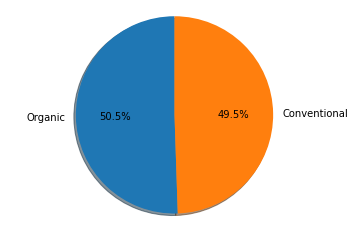

In [ ]:
labels = ['Organic','Conventional']
percents = [48, 47]

explode = (0, 0)
fig1, ax1 = plt. subplots()
ax1.pie(percents, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

##Solusi terbaik

In [ ]:
#Berdasarkan percobaan 2 : Profit tertinggi berdasarkan nilai limit dan jumlah individu (n_indvidu)

#n_individu = 100
#df1 = pd.read_csv('percobaan2_0.csv')
#df1 = pd.DataFrame(df1)
#df1

#n_individu = 75
#df1 = pd.read_csv('percobaan2_1.csv')
#df1 = pd.DataFrame(df1)
#df1

#n_individu = 50
#df1 = pd.read_csv('percobaan2_2.csv')
#df1 = pd.DataFrame(df1)
#df1

#n_individu = 20
#df1 = pd.read_csv('percobaan2_3.csv')
#df1 = pd.DataFrame(df1)
#df1

#n_individu = 10
df1 = pd.read_csv('percobaan2_4.csv')
df1 = pd.DataFrame(df1)
df1

,Unnamed: 0,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,144.502633
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
2,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
3,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
4,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
5,5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
6,6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
7,7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
8,8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000
9,9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000


Kesimpulan:
Jadi dengan nilai limit yanng semakin besar, maka profit yang dihasilkan juga semakin besar. Seperti percobaan 1 dan 2, 
dimana ketika nilai limit <=115, profit yang dihasilkan bernilai 0 / tidak memiliki profit. 
sedangkan ketika nilai limit >=120, maka terdapat profit yang dihasilkan/ memiliki profit.
Percobaan 2 adalah solusi terbaik.

## Visualisasi hubungan antara parameter dan solusi terbaik
parameter yang diobservasi: parameter metode, jumlah individu, maksimal iterasi

In [ ]:
# Main Program

dfparams = pd.read_csv('./Params_KP.csv')
dfparams['n_barang'] = 96
dfparams['lim'] = 307
dfparams['a'] = -4
dfparams['b'] = 4
dfparams['alpha'] = 1
dfparams['max_generasi'] = 5
# dfparams['']
dfparams.dropna()

,n_individu,a,b,alpha,beta0,gamma,n_barang,lim,max_generasi
0,100.0,-4,4,1,1.0,0.001,96,307,5
1,75.0,-4,4,1,1.0,0.001,96,307,5
2,50.0,-4,4,1,1.0,0.001,96,307,5
3,20.0,-4,4,1,1.0,0.001,96,307,5
4,10.0,-4,4,1,1.0,0.001,96,307,5


In [ ]:
hasils = run_FA(dfparams.dropna(),df2)
hasils

[    Barang 1  Barang 2  Barang 3  Barang 4  Barang 5  Barang 6  Barang 7  \
 0        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 1        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 2        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 3        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 4        1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 ..       ...       ...       ...       ...       ...       ...       ...   
 95       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 96       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 97       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 98       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 99       1.0       1.0       1.0       1.0       1.0       1.0       1.0   
 
     Barang 8  Barang 9  Barang 10  ...  Barang 88  Barang 89  Barang 90  

In [ ]:
hasils[4]

,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,Barang 10,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


Kesimpulan

Solusi terbaik : lim = 307 dengan variasi n_individu = 100, 75, 50, 20, 10
Dari beberapa percobaan yang telah dilakukan, yaitu:
1. Ketika maksimial iterasi semakin dibesarkan maka profit yang dihasilkan dari solusi terbaik semakin kecil
2. ketika maksimal iterasi semakin dikecilkan maka profit yang dihasilkan dari solusi terbaik semakin besar

## Visualisasi solusi terhadap iterasi

In [ ]:
# Main Program

dfparams = pd.read_csv('./Params_KP.csv')
dfparams['n_barang'] = 96
dfparams['lim'] = 307
dfparams['a'] = -4
dfparams['b'] = 4
dfparams['alpha'] = 1
dfparams['max_generasi'] = 1
# dfparams['']
dfparams.dropna()

,n_individu,a,b,alpha,beta0,gamma,n_barang,lim,max_generasi
0,100.0,-4,4,1,1.0,0.001,96,307,1
1,75.0,-4,4,1,1.0,0.001,96,307,1
2,50.0,-4,4,1,1.0,0.001,96,307,1
3,20.0,-4,4,1,1.0,0.001,96,307,1
4,10.0,-4,4,1,1.0,0.001,96,307,1


In [ ]:
hasils = run_FA(dfparams.dropna(),df2)
hasils

[    Barang 1  Barang 2  Barang 3  Barang 4  Barang 5  Barang 6  Barang 7  \
 0        0.0       1.0       0.0       1.0       1.0       1.0       0.0   
 1        1.0       1.0       0.0       1.0       1.0       0.0       1.0   
 2        0.0       1.0       1.0       1.0       1.0       1.0       0.0   
 3        0.0       1.0       1.0       1.0       1.0       1.0       0.0   
 4        1.0       0.0       1.0       1.0       1.0       1.0       1.0   
 ..       ...       ...       ...       ...       ...       ...       ...   
 95       1.0       1.0       1.0       1.0       0.0       0.0       0.0   
 96       0.0       0.0       0.0       1.0       1.0       0.0       1.0   
 97       0.0       0.0       0.0       1.0       0.0       0.0       1.0   
 98       1.0       1.0       1.0       0.0       0.0       1.0       0.0   
 99       0.0       0.0       0.0       0.0       0.0       0.0       0.0   
 
     Barang 8  Barang 9  Barang 10  ...  Barang 88  Barang 89  Barang 90  

In [ ]:
hasils[4]

,Barang 1,Barang 2,Barang 3,Barang 4,Barang 5,Barang 6,Barang 7,Barang 8,Barang 9,Barang 10,...,Barang 88,Barang 89,Barang 90,Barang 91,Barang 92,Barang 93,Barang 94,Barang 95,Barang 96,Profit
0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,103.150640
1,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,102.733375
2,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,97.277730
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,91.199484
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,90.817396
5,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,90.795932
6,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,82.040707
7,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,79.654345
8,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,70.634328
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Kesimpulan:

tujuan analisis : mencari solusi untuk mengkategorikan atau menentukan alpukat yang memiliki profit atau keuntungan terbaik.

Berdasarkan tujuan analisis dan percobaan yang telah dilakukan, untuk mendapatkan solusi terbaik maka maksimal iterasi harus dibuat seminimal mungkin. agar profit yang dihasilkan semakin banyak.